In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import pyccl as ccl
from scipy.optimize import minimize
import emcee
import astropy.cosmology
import astropy.units as u
from chainconsumer import ChainConsumer
import pickle
import pandas as pd
import sacc
from scipy.stats import norm
from numpy.random import normal
from helper_functions import *
import astropy.table
import colorsys

plt.rcParams.update({
    "text.usetex": False,
    "font.family": "sans-serif",
    "font.sans-serif": ["Times"]
})
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
# %matplotlib inline
plt.rcParams.update({'font.size':14})


# Load data

In [2]:
skysim_area = np.pi / 2 * 3282.8 # <- 1 steradian
# dc2_area = 295.4375
dc2_area = 294.16
print(skysim_area/dc2_area)

17.52995030460391


In [3]:
# Load in skysim_all:
skysim_all_data = pd.DataFrame()
covlist_skysim = []
nz_df = pd.DataFrame()
zmin=0.2
for i in range(5):
    zmax=zmin+.2
    tab = astropy.table.Table.read(f'skysim5000/w_skysim_all_24p1/w_skysim5000_{zmin:.1f}_{zmax:.1f}_lt24p1_all_norsd.fits.gz')
    skysim_all_data[f'theta_{i}'] = tab['theta'].byteswap().newbyteorder()
    skysim_all_data[f'w_{i}'] = tab['w'].byteswap().newbyteorder()
    skysim_all_data[f'werr_{i}'] = tab['w_err'].byteswap().newbyteorder()
    nz_tab = astropy.table.Table.read(f'skysim5000/w_skysim_all_24p1/dndz_skysim5000_{zmin:.1f}_{zmax:.1f}_lt24p1_all_norsd.fits.gz')
    nz_df[f'z_{i}'] = nz_tab['z'].byteswap().newbyteorder()
    nz_df[f'Nz_{i}'] = nz_tab['dndz'].byteswap().newbyteorder()
    covlist_skysim.append(np.load(f'skysim5000/w_skysim_all_24p1/skysim_{0.2+0.2*i:.1f}_{0.4+0.2*i:.1f}_lt24p1_all_cov_norsd.npy'))
    # print(f'skysim5000/w_skysim_all_24p1/w_skysim5000_{zmin:.1f}_{zmax:.1f}_lt24p1_all_norsd.fits.gz')
    zmin+=.2

In [4]:
wtheta = astropy.table.Table.read('DC2_DR6_wtheta_2_29_2024_5bin.fits.gz')
nz, dndz = np.load('DC2_DR6_Nz_2_29_2024_5bin.npy', allow_pickle=True)
covlist = np.array(covlist_skysim)*(skysim_area/dc2_area)
    
df_dict = {}
nz_dict = {}
for key in nz.keys():
    df_list = []
    nz_list = []
    for i in range(5):
        nz_list.append(pd.DataFrame([nz[key][i], dndz[key][i]])
            .rename(index={0: f"Nz_{i}", 1: f"z_{i}"})
            .T
        )
    
        if 'true' in key:
            df_list.append(pd.DataFrame([wtheta[f'theta_{key}_{i}'], wtheta[f'w_{key}_{i}'], wtheta[f'w_err_{key}_{i}']])
            .rename(index={0: f"theta_{i}", 1: f"w_{i}", 2: f"werr_{i}"})
            .T)
        elif '1t1' in key:
            df_list.append(pd.DataFrame([wtheta[f'theta_obs_1to1_{i}'], wtheta[f'w_obs_1to1_{i}'], wtheta[f'w_err_obs_1to1_{i}']])
            .rename(index={0: f"theta_{i}", 1: f"w_{i}", 2: f"werr_{i}"})
            .T)
        elif 'mtm' in key:
            df_list.append(pd.DataFrame([wtheta[f'theta_obs_manytomany_{i}'], wtheta[f'w_obs_manytomany_{i}'], wtheta[f'w_err_obs_manytomany_{i}']])
            .rename(index={0: f"theta_{i}", 1: f"w_{i}", 2: f"werr_{i}"})
            .T)
        elif 'meas_other' in key:
            df_list.append(pd.DataFrame([wtheta[f'theta_obs_other_{i}'], wtheta[f'w_obs_other_{i}'], wtheta[f'w_err_obs_other_{i}']])
            .rename(index={0: f"theta_{i}", 1: f"w_{i}", 2: f"werr_{i}"})
            .T)
        elif 'artifact' in key:
            df_list.append(pd.DataFrame([wtheta[f'theta_{key}_{i}'], wtheta[f'w_{key}_{i}'], wtheta[f'w_err_{key}_{i}']])
            .rename(index={0: f"theta_{i}", 1: f"w_{i}", 2: f"werr_{i}"})
            .T)
        else:
            df_list.append(pd.DataFrame([wtheta[f'theta_obs_{key}_{i}'], wtheta[f'w_obs_{key}_{i}'], wtheta[f'w_err_obs_{key}_{i}']])
            .rename(index={0: f"theta_{i}", 1: f"w_{i}", 2: f"werr_{i}"})
            .T)
    df_dict[key] = pd.concat(df_list, axis=1)
    nz_dict[key] = pd.concat(nz_list, axis=1)

In [5]:
data_vector_list = {
    key: (df_dict[key], nz_dict[key], covlist) for key in df_dict.keys()
}

In [6]:
data_vector_skysim = (skysim_all_data, nz_df, covlist_skysim)

In [7]:
df_dict.keys()

dict_keys(['all', '1t1', 'mtm', 'meas_other', 'artifact', 'true_lost', 'true_all'])

In [8]:
keys_to_use = ['all', '1t1', 'mtm', 'true_all']

# Define Model

In [9]:
def model(pars, data, nz_out):
    Omega_m, b1, b2, b3, b4, b5 = pars
    b = np.array([b1, b2, b3, b4, b5,])
    cosmo = ccl.Cosmology(Omega_b=0.0448, Omega_c=Omega_m-0.0448, n_s=0.963, h=0.71, sigma8=0.8)
    return model_ccl_helper(data, b, nz_out, cosmo, has_rsd=False)

def prior(pars):
    Omega_m, b1, b2, b3, b4, b5 = pars
    if (0.1 < Omega_m < 0.9) & \
    (0 < b1 < 3) & \
    (0 < b2 < 3) & \
    (0 < b3 < 3) & \
    (0 < b4 < 3) & \
    (0 < b5 < 3):
        pr =  norm.pdf(Omega_m-0.0448, 0.22, 0.2) *\
        norm.pdf(b1, 1.9, 0.9) *\
        norm.pdf(b2, 1.9, 0.9) *\
        norm.pdf(b3, 1.9, 0.9) *\
        norm.pdf(b4, 1.9, 0.9) *\
        norm.pdf(b5, 1.9, 0.9)
    
        return np.log(pr) 
    else:
        return -np.inf

In [10]:
data_vector = data_vector_list['true_all']
angle_list = compute_scale_cuts(8500)
txp_angles = [42.81, 26.93, 20.21, 16.52, 14.21]
parnames = ['$\\Omega_m$', '$b_1$', '$b_2$', '$b_3$', '$b_4$', '$b_5$',]
masks, inv_cov = preprocess(data_vector, angle_list)
tarr = [0.265, 1.229, 1.362, 1.502, 1.648, 1.799]  
parr = [0.265, 0.91, 1.09, 1.226, 1.34, 1.58]
print(log_like(tarr, data_vector[0], data_vector[1], inv_cov, masks, model, prior))

-271.83646504028195


In [11]:
def rgb2hex(r,g,b):
    return "#{:02x}{:02x}{:02x}".format(r,g,b)

#h between 0 and 360
#s between 0 and 100
#v between 0 and 100

def hsv2hex(h, s, v):
    h /= 360
    s /= 100
    v /= 100
    return rgb2hex(*[int(255*x) for x in colorsys.hsv_to_rgb(h, s, v)])

#ORDER = ALL, OTO, MTM, TRUTH, 
hsvlist = [(242, 61, 70), (173, 52, 60), (42, 61, 60), (331, 89, 70)]

single_color_hex = []
for hsvl in hsvlist:
    print(hsv2hex(hsvl[0], hsvl[1], hsvl[2]+20))
    single_color_hex.append(hsv2hex(hsvl[0], hsvl[1], hsvl[2]+20))

#5e59e5
#61ccbf
#cca64f
#e5197b


In [12]:
single_color_hex

['#5e59e5', '#61ccbf', '#cca64f', '#e5197b']

In [13]:
names = ['Observed All', 'One-to-One', 'Multiple-to-One', 'Truth', ]

In [14]:
z_mean_table = pd.read_csv('redshift_means.txt', delimiter=' ')
z_mean_table['difference'] = z_mean_table['All-Observed']-z_mean_table['One-to-One']

In [15]:
zmin = 0.2; zmax = 1.2 
n_bins = 5
binlist = np.linspace(zmin,zmax,n_bins+1)

print('MEANS')
print('Redshift & One-to-One & Multiple-to-One & All Observed & \\Delta\\\\')
print('\hline')
for i in range(n_bins):
    zmin = binlist[i]; zmax = binlist[i+1]
    print(f'''{zmin:.1f}-{zmax:.1f} & 
${z_mean_table.iloc[i]['One-to-One']:.4f}$ & \
${z_mean_table.iloc[i]['Multiple-to-One']:.4f}$ & \
${z_mean_table.iloc[i]['All-Observed']:.4f}$ & \
${z_mean_table.iloc[i]['difference']:.4f}$\\\\''')
print('\hline') 

MEANS
Redshift & One-to-One & Multiple-to-One & All Observed & \Delta\\
\hline
0.2-0.4 & 
$0.3078$ & $0.3080$ & $0.3079$ & $0.0001$\\
0.4-0.6 & 
$0.5035$ & $0.5037$ & $0.5036$ & $0.0001$\\
0.6-0.8 & 
$0.7037$ & $0.7039$ & $0.7038$ & $0.0001$\\
0.8-1.0 & 
$0.8937$ & $0.8947$ & $0.8943$ & $0.0006$\\
1.0-1.2 & 
$1.0891$ & $1.0909$ & $1.0902$ & $0.0011$\\
\hline


In [16]:
zmin = 0.2; zmax = 1.2 
n_bins = 5
binlist = np.linspace(zmin,zmax,n_bins+1)

print('MEDIANS')
print('Redshift & One-to-One & Multiple-to-One & All Observed & \\Delta\\\\')
print('\hline')
for i in range(n_bins):
    zmin = binlist[i]; zmax = binlist[i+1]
    print(f'''{zmin:.1f}-{zmax:.1f} & 
${z_mean_table.iloc[i+5]['One-to-One']:.4f}$ & \
${z_mean_table.iloc[i+5]['Multiple-to-One']:.4f}$ & \
${z_mean_table.iloc[i+5]['All-Observed']:.4f}$ & \
${z_mean_table.iloc[i+5]['difference']:.4f}$\\\\''')
print('\hline') 

MEDIANS
Redshift & One-to-One & Multiple-to-One & All Observed & \Delta\\
\hline
0.2-0.4 & 
$0.3125$ & $0.3126$ & $0.3126$ & $0.0001$\\
0.4-0.6 & 
$0.5045$ & $0.5049$ & $0.5047$ & $0.0002$\\
0.6-0.8 & 
$0.7055$ & $0.7058$ & $0.7057$ & $0.0002$\\
0.8-1.0 & 
$0.8903$ & $0.8919$ & $0.8912$ & $0.0009$\\
1.0-1.2 & 
$1.0823$ & $1.0853$ & $1.0841$ & $0.0018$\\
\hline


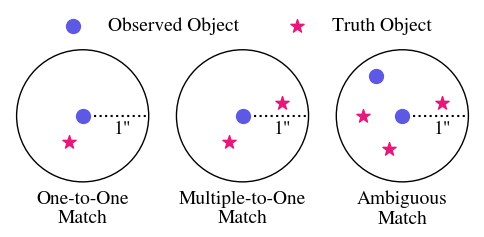

In [19]:
col1=single_color_hex[0]
col2=single_color_hex[3]

fig, axs = plt.subplots(1, 3, figsize=(6, 3))
# fig.tight_layout()
fig.subplots_adjust(wspace=.1)
size=0.5
 
axs[0].set_aspect(1)
axs[0].axis('off')
axs[0].add_patch(plt.Circle((0.5, 0.5), size, fill=False, edgecolor='black', lw=1))
axs[0].plot([.5, 1],[.5, .5], color='black', ls=":")
axs[0].scatter(.5, .5, s=100, zorder=11, color=col1)
axs[0].scatter(.4, .3, s=100, zorder=11, color=col2, marker='*')
axs[0].text(
        0.87,
        0.4,
        f'''1"''',
        horizontalalignment="right",
        verticalalignment="center",
    )
axs[0].text(
        0.5,
        -.2,
        f"One-to-One\nMatch",
        horizontalalignment="center",
        verticalalignment="center",
    )

axs[1].set_aspect(1)
axs[1].axis('off')
axs[1].add_patch(plt.Circle((0.5, 0.5), size, fill=False, edgecolor='black', lw=1))
axs[1].plot([.5, 1],[.5, .5], color='black', ls=":")
axs[1].scatter(.5, .5, s=100, zorder=11, color=col1)
axs[1].scatter([.4, .8], [.3, .6], s=100, zorder=11, color=col2, marker='*')
axs[1].text(
        0.87,
        0.4,
        f'''1"''',
        horizontalalignment="right",
        verticalalignment="center",
    )
axs[1].text(
        0.5,
        -.2,
        f"Multiple-to-One\nMatch",
        horizontalalignment="center",
        verticalalignment="center",
    )

axs[2].set_aspect(1)
axs[2].axis('off')
axs[2].add_patch(plt.Circle((0.5, 0.5), size, fill=False, edgecolor='black', lw=1))
axs[2].plot([.5, 1],[.5, .5], color='black', ls=":")
axs[2].scatter([.5, .3], [.5, .8], s=100, zorder=11, color=col1, label='Observed Object')
axs[2].scatter([.4, .8, .2], [.25, .6, .5], s=100, zorder=11, color=col2, marker='*', label='Truth Object')
axs[2].text(
        0.87,
        0.4,
        f'''1"''',
        horizontalalignment="right",
        verticalalignment="center",
    )
axs[2].text(
        0.5,
        -.2,
        f"Ambiguous\nMatch",
        horizontalalignment="center",
        verticalalignment="center",
    )

axs[2].set_aspect(1)
axs[2].axis('off')
axs[2].legend(loc='upper center', bbox_to_anchor=(-.6, 1.3), ncol=2, fancybox=False, framealpha=1, edgecolor='1')
plt.savefig('matching_graphic.png', dpi=300, format='png', bbox_inches='tight')

In [26]:
# MODEL+RESIDUAL PLOTTER
def plot_allwtheta_residual_test(
    resid_limits=(-3, 2),
    delta_or_ratio="delta",
    yticks=None,
):
    # STYLES
    marker = "."
    capsize = 2
    ls = "-"
    markersize = 7
    lw = 1.5
    model_color = "#273E47"
    resid_label = "$\\Delta w/\\sigma_{w}$"
    
    # h, s, v = color
    # hsvlist = [(h, s, round(v-30+(15*i), 3)) for i in range(5)]
    # colorlist = [hsv2hex(*hsvlist[i]) for i in range(5)]
    
    # CODE BEGINS
    # data, nz, cov = data_vector

    # PLOT
    fig, axs = plt.subplots(2, 5, figsize=(15, 3), height_ratios=[4, 1])
    for i in range(len(axs[1])):
        # err = np.sqrt(cov[i].diagonal()) if use_cov else data[f"werr_{i}"]
        axs[0][i].set_title(
            f"${np.round((.2*i)+.2, 2)} < z < {np.round((.2*i)+.4, 2)}$"
        )
        axs[0][i].axvspan(
            0, txp_angles[i], alpha=0.1, edgecolor="black", facecolor="gray"
        )
        offset = 0.93
        for j, key in enumerate(keys_to_use):
            axs[0][i].errorbar(data_vector_list[key][0][f'theta_{i}']*(offset), 
                        data_vector_list[key][0][f'w_{i}']*data_vector_list[key][0][f'theta_{i}'],
                        data_vector_list[key][0][f'werr_{i}']*data_vector_list[key][0][f'theta_{i}'], 
                        color=single_color_hex[j], label=names[j],
                        # marker=marker,
                        # capsize=capsize,
                        ls=':',
                        # markersize=markersize,
                        lw=lw,)
            offset += .05
        residual_plot_helper(axs, 0, i, "linear")
        axs[0][i].set_ylim(-0.2, 0.55)
        axs[0][i].axes.xaxis.set_ticklabels([])
        # RESIDUALS
        axs[1][i].axvspan(
            0, txp_angles[i], alpha=0.1, edgecolor="black", facecolor="gray"
        )
        
        axs[1][i].axhline(0, 0, 500, color="black", ls=":")
        
        for j, key in enumerate(keys_to_use[:3]):
            axs[1][i].plot(data_vector_list[key][0][f'theta_{i}'], 
                        (data_vector_list[key][0][f'w_{i}'] - data_vector_list['true_all'][0][f'w_{i}']) / data_vector_list[key][0][f'werr_{i}'],
                        color=single_color_hex[j], label=names[j],
                        # marker=marker,
                        # capsize=capsize,
                        ls=ls,
                        # markersize=markersize,
                        lw=lw,)
            
        residual_plot_helper(axs, 1, i, "linear")
        axs[1][i].set_ylim(resid_limits[0], resid_limits[1])
        axs[1][i].set_xlabel("$\\theta$ [arcmin]")
        if yticks is not None:
            axs[1][i].set_yticks(yticks)
        axs[1][i].set_yticks((-3, 0))
        if i == 0:
            axs[0][i].set_ylabel("$\\theta \\times w(\\theta)$", labelpad=-1)
            axs[1][i].set_ylabel(resid_label, labelpad=10)
        else:
            axs[0][i].axes.yaxis.set_ticklabels([])
            axs[1][i].axes.yaxis.set_ticklabels([])
        if i == 2:
            axs[0][i].legend(loc="upper center", ncol=4, bbox_to_anchor=(0.5, 1.5), fancybox=False, framealpha=1, edgecolor='0')
    fig.subplots_adjust(hspace=0, wspace=0.1)
    plt.show()
    # plt.savefig('wtheta_comparison_thetaxw.png', dpi=300, format='png', bbox_inches='tight')
    

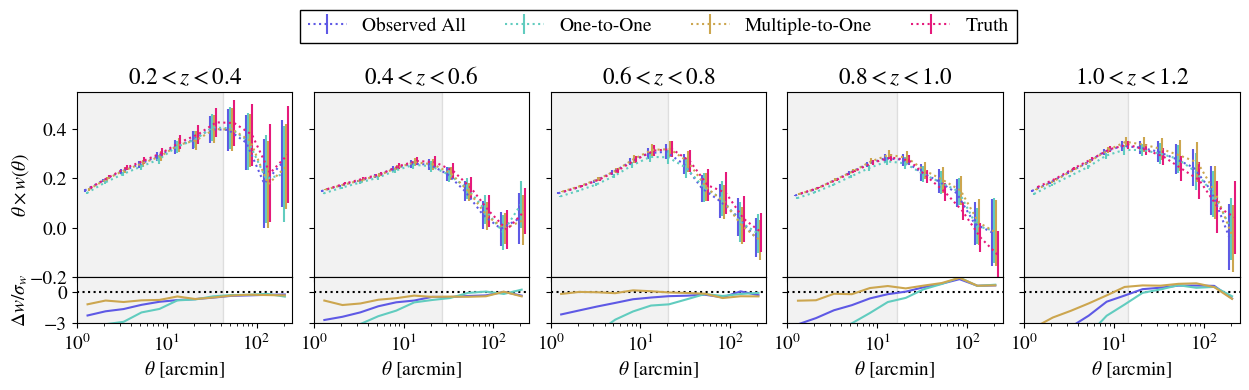

In [27]:
plot_allwtheta_residual_test(resid_limits=(-3, 1.5))

# Plots and Analysis

In [28]:
chain_list = []
for key in keys_to_use:
    chain_list.append(np.load(f'final_samples/chain_dc2_skysimjk_txpcut_{key}_Mar1.npy'))
chain_list.append(np.load('final_samples/chain_skysim5000_skysimjk_txpcut_Aug3.npy'))
chain_list = np.array(chain_list)

parnames = ['$\\Omega_{\\rm m}$', '$b_1$', '$b_2$', '$b_3$', '$b_4$', '$b_5$',]

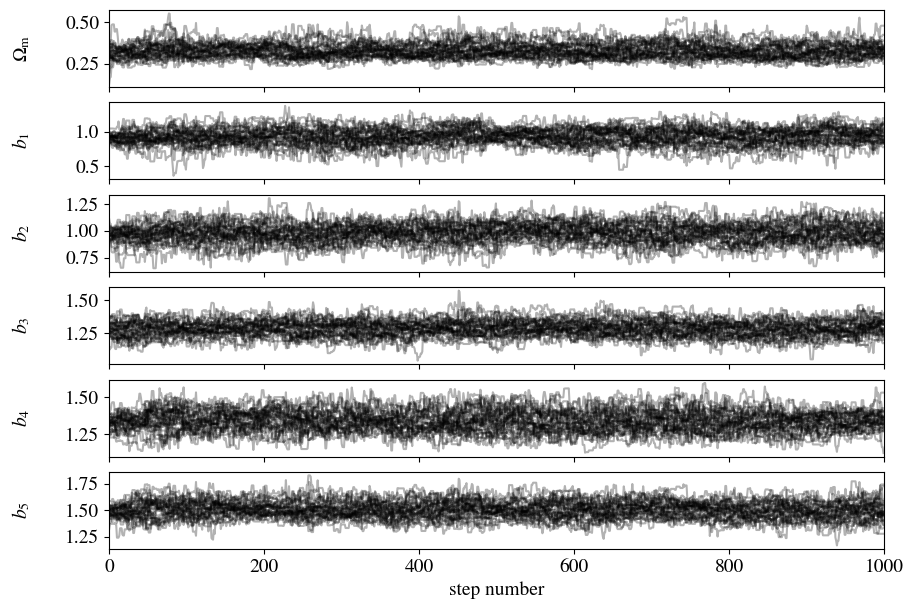

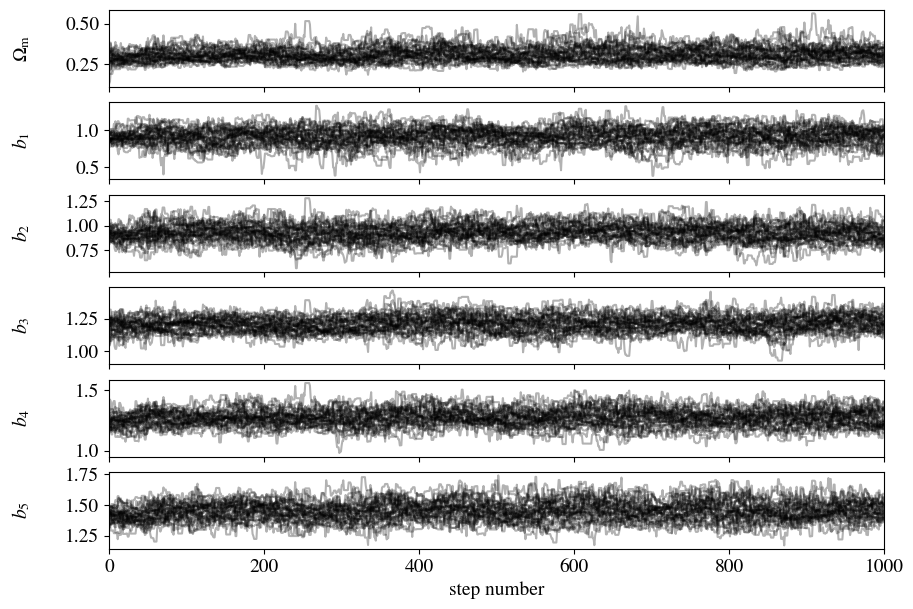

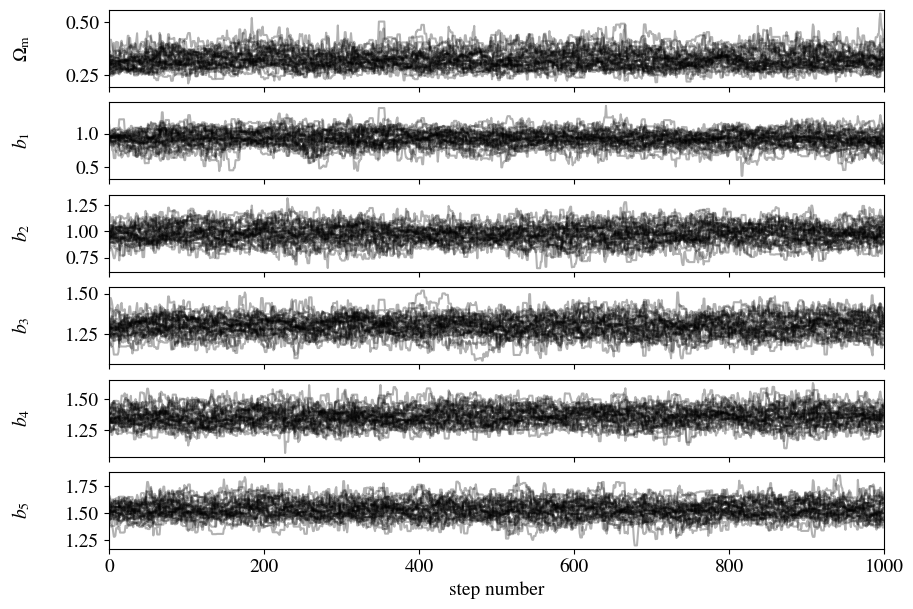

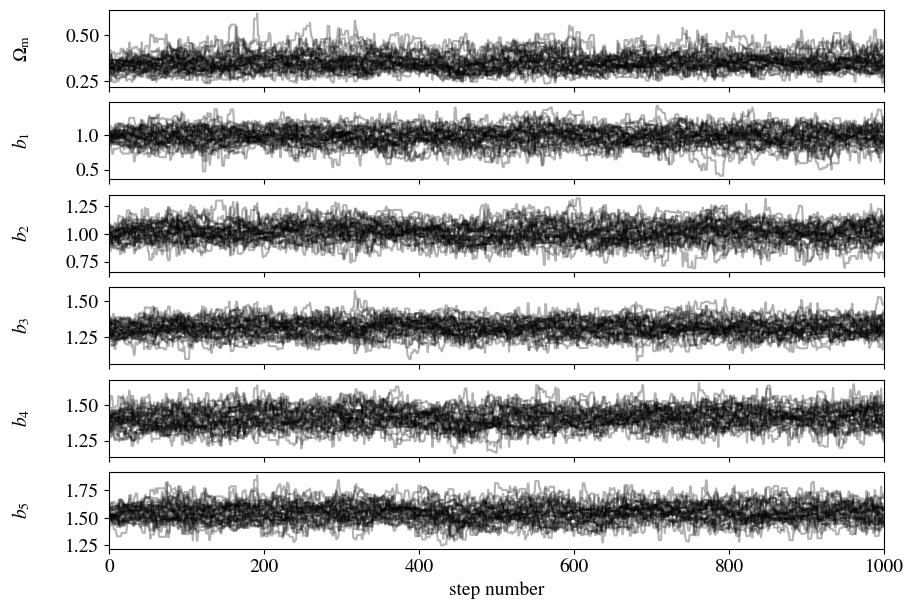

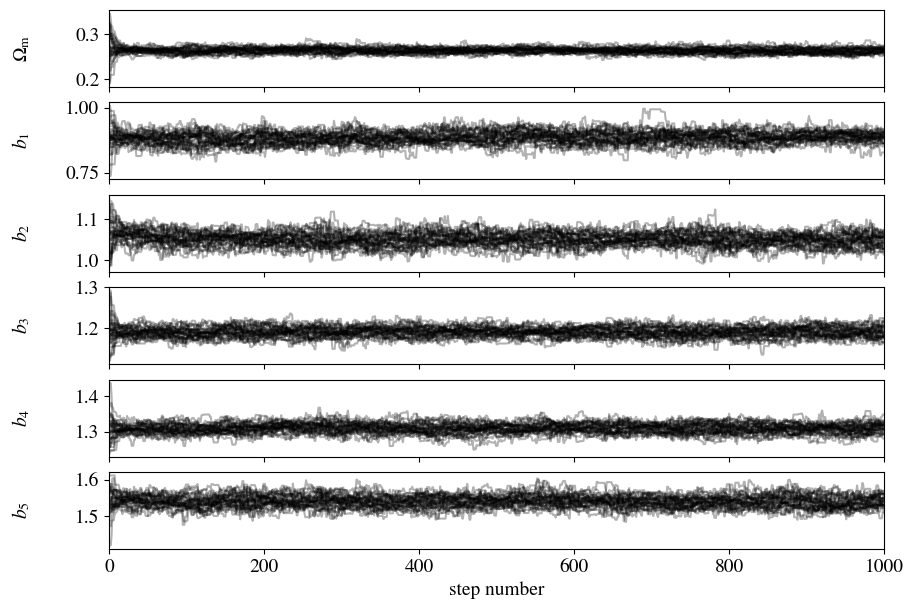

In [29]:
plot_convergence(chain_list, parnames)

In [30]:
chain_trimmed = []
for i in chain_list:
    chain_trimmed.append(process_stuck_chain(i, 100))
chain_trimmed = np.array(chain_trimmed)

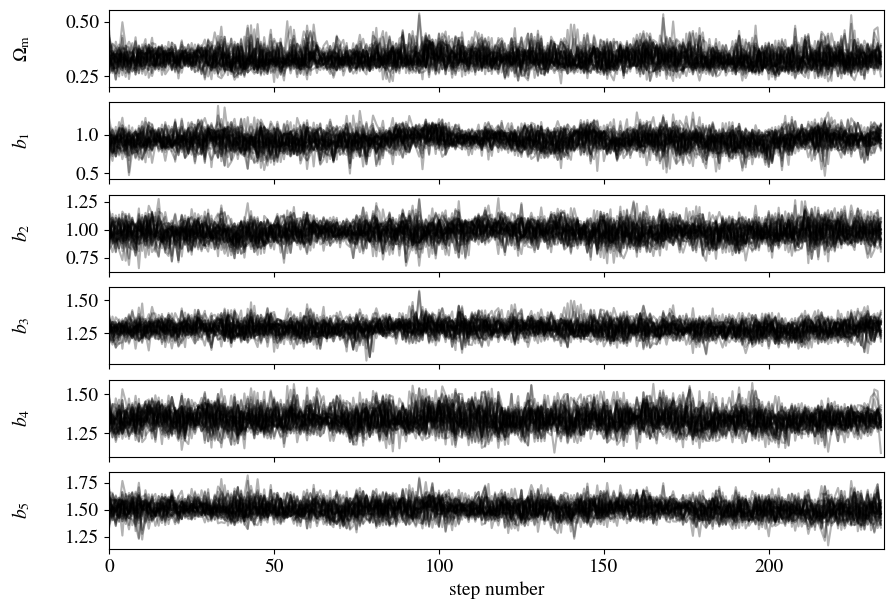

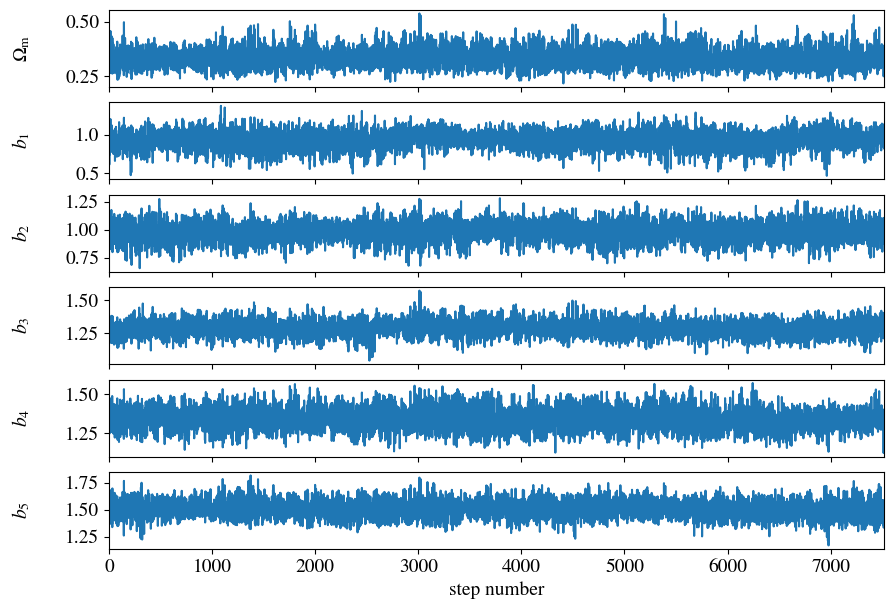

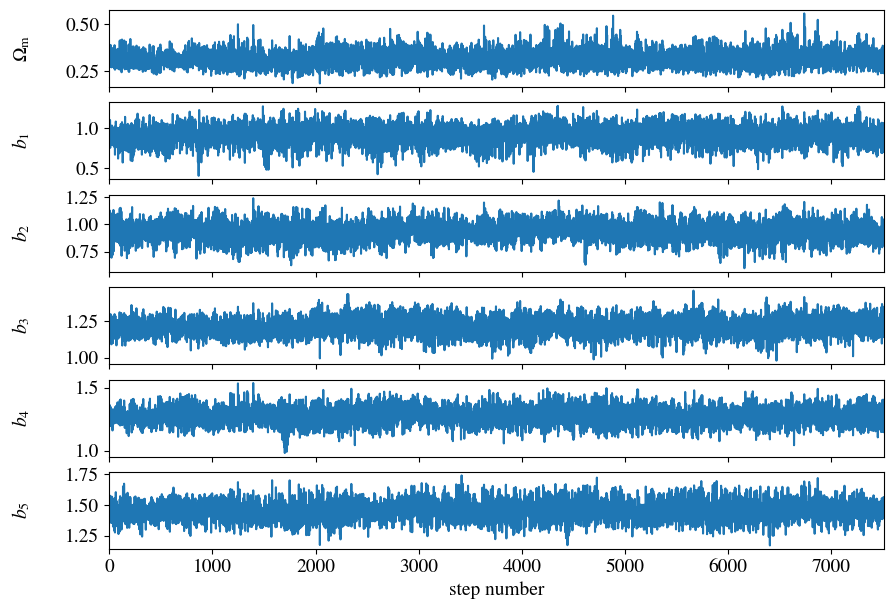

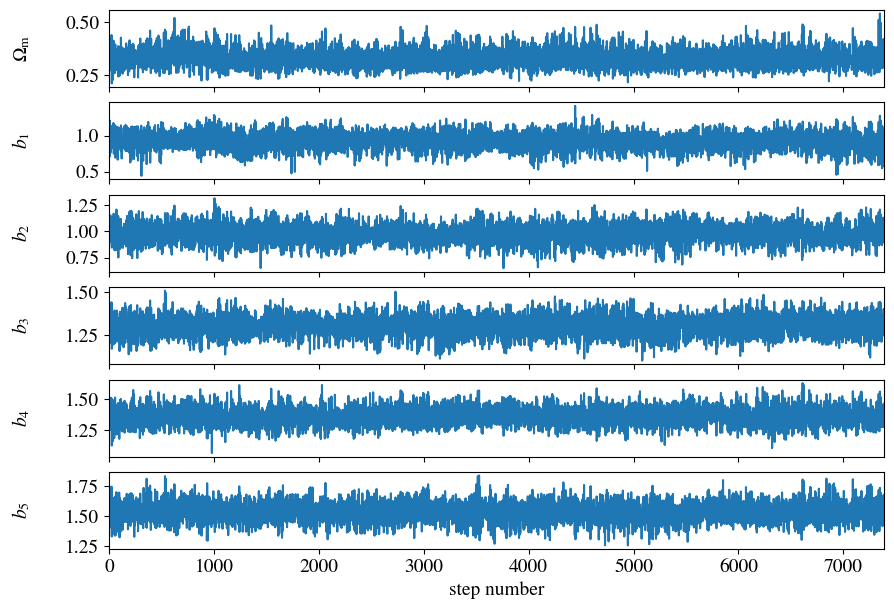

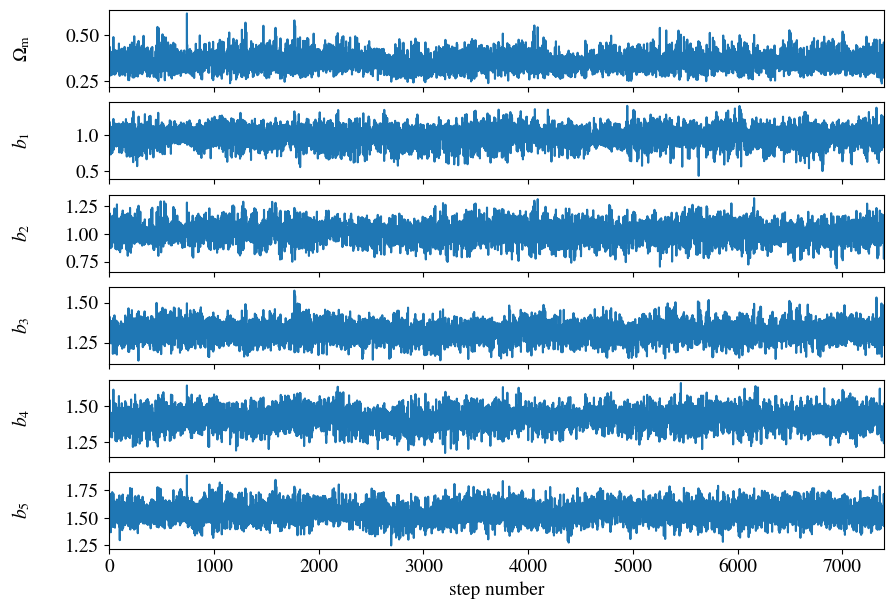

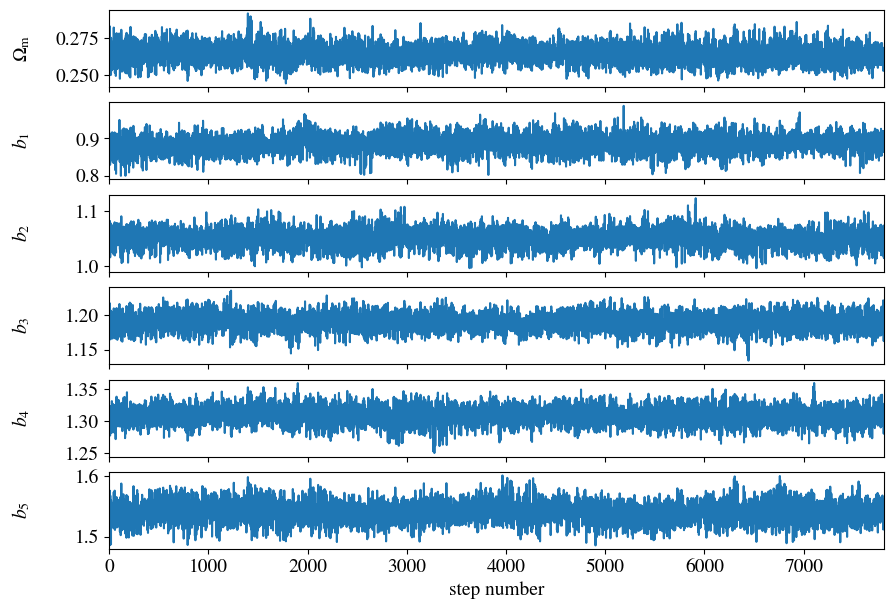

In [31]:
plot_convergence(chain_trimmed, parnames)

In [32]:
prior_list = np.array([normal(0.22+0.0448, 0.2, size=100000),
                       normal(1.9, 0.9, size=100000),
                       normal(1.9, 0.9, size=100000),
                       normal(1.9, 0.9, size=100000),
                       normal(1.9, 0.9, size=100000),
                       normal(1.9, 0.9, size=100000),])

In [33]:
names = ['Observed All', 'One-to-One', 'Multiple-to-One', 'Truth']
for i in range(4):
    print(names[i])
    print(keys_to_use[i])

Observed All
all
One-to-One
1t1
Multiple-to-One
mtm
Truth
true_all


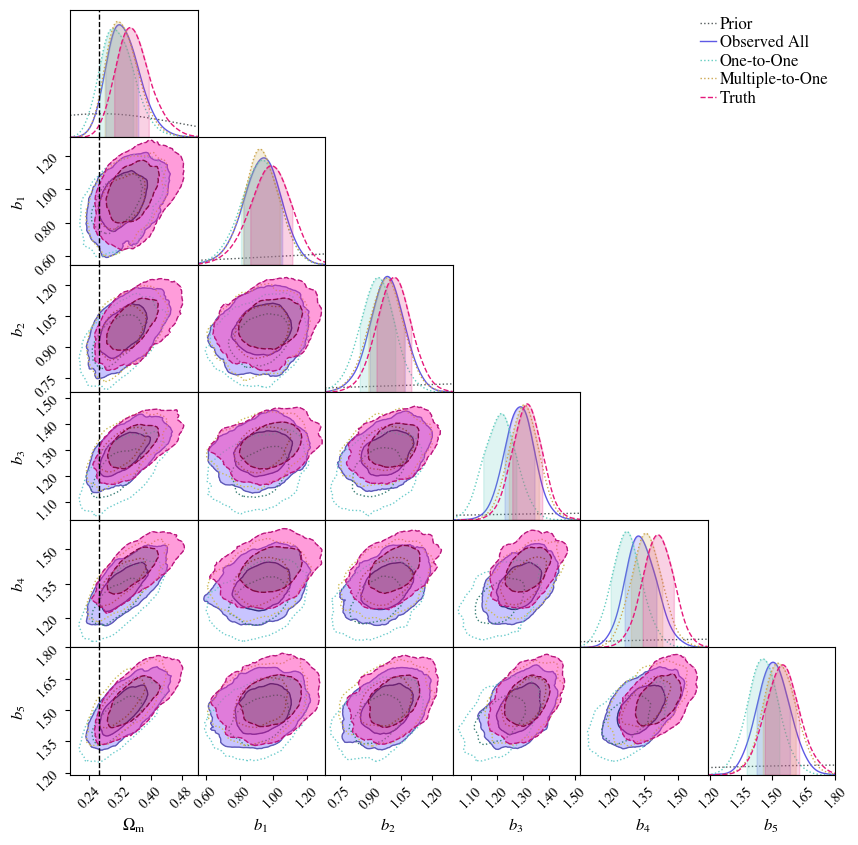

In [41]:
c = ChainConsumer()
# colors = ['#63D6FF', '#CB63FF', '#e52783', '#ffae00']
colors = single_color_hex

c.add_chain(prior_list.T, parameters=parnames, name="Prior", show_as_1d_prior=True, color="#535A5B")

for i in range(len(names)):
    c.add_chain(chain_trimmed[i], parameters=parnames, name=names[i], color=colors[i])

# c.configure(usetex=False, shade=True, bar_shade=[False, True, True, True, True], kde=True, legend_color_text=False, 
#             linestyles=[":", "-", "-", "-", "-"], linewidths=1.0)
c.configure(usetex=False, shade=[False, True, False, False, True], bar_shade=[False, True, True, True, True], kde=True, legend_color_text=False, 
            linestyles=[":", "-", ":", ":", "--"], linewidths=1.0)

fig = c.plotter.plot(truth=[0.265, ],
                    #   0.86650961, 1.06271354, 1.18494648, 1.30541203, 1.55081382],
               extents={"$\Omega_{\\rm m}$": (.19,.52),
                        "$b_1$": (.55,1.31),
                        "$b_2$": (0.68,1.3),
                        "$b_3$": (1.03,1.52),
                        "$b_4$": (1.07,1.63),
                        "$b_5$": (1.19,1.8),
                       });
for i in range(len(fig.axes)):
    fig.axes[i].xaxis.set_major_formatter(plt.FormatStrFormatter('%.2f'))
    fig.axes[i].yaxis.set_major_formatter(plt.FormatStrFormatter('%.2f'))
# plt.savefig('cornerplot_noshade.png', dpi=300, format='png', bbox_inches='tight')
plt.savefig('cornerplot_final.png', dpi=300, format='png', bbox_inches='tight')
# plt.show()


In [30]:
sigma_b_dict = {}
b_dict = {}
OmM_means = []
OmM_sigs = []
for i in range(4):
    idx = i+1 # Skip the first index, since that's just the prior
    post_dict = c.analysis.get_summary()[idx]
    sigma_b_list = [post_dict[f'$b_{i+1}$'][2] - post_dict[f'$b_{i+1}$'][0] for i in range(5)]
    b_list = [post_dict[f'$b_{i+1}$'][1] for i in range(5)]
    sigma_b_dict[names[i]] = sigma_b_list
    b_dict[names[i]] = b_list
    OmM_means.append(post_dict['$\\Omega_{\\rm m}$'][1])
    OmM_sigs.append(post_dict['$\\Omega_{\\rm m}$'][2] - post_dict['$\\Omega_{\\rm m}$'][0])

In [31]:
# b/sigma_b
for name in names:
    print(name, f': {np.divide(b_dict[name], sigma_b_dict[name])}')

Observed All : [ 4.10241415  5.77005468 11.18557013  9.46204148  9.42217121]
One-to-One : [3.92426591 5.45054301 9.58241433 9.22348451 9.30223772]
Multiple-to-One : [ 4.20083926  5.64518204 11.31701754  9.82931582  9.69106659]
Truth : [ 3.94332936  5.99575446 11.40415094 10.3168099   9.41712598]


In [34]:
# (b_truth-b) / sigma_b
for i in range(3):
    name = names[i]
    numerator = np.subtract(b_dict['Truth'], b_dict[name])
    denominator = np.sqrt(np.add(np.square(sigma_b_dict[name]), np.square(sigma_b_dict['Truth'])))
    print(name, f': {np.round(numerator/denominator, 3)}')

Observed All : [0.135 0.139 0.16  0.439 0.201]
One-to-One : [0.162 0.33  0.571 0.709 0.425]
Multiple-to-One : [0.212 0.161 0.064 0.278 0.1  ]


In [36]:
# Same as above but for OmM
print(names)
numerator = np.subtract(OmM_means[3], OmM_means)
denominator = np.sqrt(np.add(np.square(OmM_sigs), np.square(OmM_sigs[3])))
print(np.round(numerator/denominator, 3))

['Observed All', 'One-to-One', 'Multiple-to-One', 'Truth']
[0.224 0.355 0.253 0.   ]


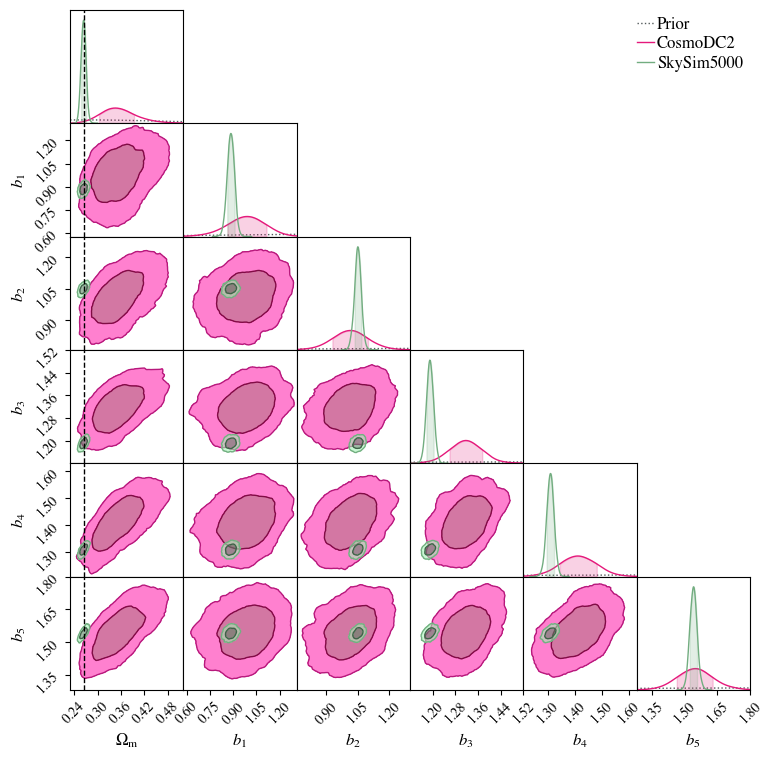

In [38]:
c = ChainConsumer()
# colors = ['#63D6FF', '#CB63FF', '#e52783', '#ffae00']
colors = single_color_hex
c.add_chain(prior_list.T, parameters=parnames, name="Prior", show_as_1d_prior=True, color="#535A5B")
i=3
c.add_chain(chain_trimmed[i], parameters=parnames, name='CosmoDC2', color=colors[i])
c.add_chain(chain_trimmed[-1], parameters=parnames, name='SkySim5000', color='#72ad80')

c.configure(usetex=False, shade=True, bar_shade=[False, True, True,], kde=True, legend_color_text=False, 
            linestyles=[":", "-", "-",], linewidths=1.0)
# c.configure(usetex=False, shade=True, bar_shade=[False, True, True,], kde=False, legend_color_text=False, 
#             linestyles=[":", "-", "-",], linewidths=1.0)

fig = c.plotter.plot(truth=[0.265, ],
                    #   0.86650961, 1.06271354, 1.18494648, 1.30541203, 1.55081382],
               extents={"$\Omega_{\\rm m}$": (.23,.52),
                        "$b_1$": (.58,1.31),
                        "$b_2$": (0.76,1.3),
                        "$b_3$": (1.12,1.52),
                        "$b_4$": (1.21,1.63),
                        "$b_5$": (1.28,1.8),
                       }, figsize=(8,8));

for i in range(len(fig.axes)):
    fig.axes[i].xaxis.set_major_formatter(plt.FormatStrFormatter('%.2f'))
    fig.axes[i].yaxis.set_major_formatter(plt.FormatStrFormatter('%.2f'))
plt.savefig('cornerplot_skysim.png', dpi=300, format='png', bbox_inches='tight')
# plt.show()

# Grad Minimization

In [39]:
data_vector = data_vector_list['true_all']

In [40]:
angles_to_try = np.linspace(2000, 20000, 11)
print(angles_to_try)

[ 2000.  3800.  5600.  7400.  9200. 11000. 12800. 14600. 16400. 18200.
 20000.]


In [41]:
reslist = []
for a in angles_to_try:
    angle_list = compute_scale_cuts(a)
    res = gradient_minimize(parr, data_vector, angle_list, model, prior)
    reslist.append(res)
    print(res)

 final_simplex: (array([[0.30159091, 0.89623769, 1.03776997, 1.15689777, 1.31962843,
        1.5641387 ],
       [0.30159091, 0.8962377 , 1.03776997, 1.15689777, 1.31962843,
        1.5641387 ],
       [0.30159091, 0.8962377 , 1.03776997, 1.15689777, 1.31962843,
        1.5641387 ],
       [0.30159091, 0.8962377 , 1.03776997, 1.15689777, 1.31962843,
        1.5641387 ],
       [0.30159091, 0.8962377 , 1.03776997, 1.15689777, 1.31962843,
        1.5641387 ],
       [0.30159091, 0.8962377 , 1.03776997, 1.15689777, 1.31962843,
        1.5641387 ],
       [0.30159091, 0.89623769, 1.03776997, 1.15689777, 1.31962843,
        1.5641387 ]]), array([32.91135322, 32.91135335, 32.91138218, 32.91138218, 32.91138228,
       32.91138234, 32.91138235]))
           fun: 32.91135322014276
       message: 'Optimization terminated successfully.'
          nfev: 399
           nit: 193
        status: 0
       success: True
             x: array([0.30159091, 0.89623769, 1.03776997, 1.15689777, 1.31962843,

In [42]:
# Best-fit Omega M values:
[res.x[0] for res in reslist]

[0.30159091404829463,
 0.30813795978627323,
 0.30978354126792573,
 0.31872085274515444,
 0.32211422022919234,
 0.3339047051524071,
 0.35058249811513187,
 0.328934021195235,
 0.32419708215340615,
 0.32470126120659876,
 0.2865496707443861]

In [43]:
chi2_list = []
dof_list = []
for i, a in enumerate(angles_to_try):
    angle_list = compute_scale_cuts(a)
    vals = reslist[i].x

    data = data_vector[0]
    processor = Data_Processor(data_vector, None, model, parnames, vals)

    # Calculate Chi2
    masks, inv_cov = preprocess(data_vector, angle_list)
    w_model = processor.ccl_guess
    resid = chi2(data, w_model, inv_cov, masks)
    n_dof = [len(data[f"w_{i}"][masks[i]]) for i in range(len(masks))]
    n_pars = len(parnames)
    
    chi2_list.append(np.sum(resid))
    dof_list.append(np.sum(n_dof))

    print(f'{np.sum(resid):.3f} / ({np.sum(n_dof)} - {n_pars})')

55.636 / (48 - 6)
26.932 / (42 - 6)
19.222 / (37 - 6)
13.225 / (33 - 6)
13.153 / (32 - 6)
12.346 / (31 - 6)
10.899 / (28 - 6)
10.022 / (27 - 6)
9.880 / (26 - 6)
9.542 / (24 - 6)
7.571 / (23 - 6)


In [44]:
astropy_cosmo = astropy.cosmology.FlatLambdaCDM(
    H0=71, Om0=0.265, Ob0=0.0448
)  # cosmoDC2 params
z_arr = np.array([0.3 + 0.2 * i for i in range(5)])  # 5 bins
kpc_per_arcm = astropy_cosmo.kpc_comoving_per_arcmin(z_arr)
txp_kpc = kpc_per_arcm * (txp_angles*u.arcmin)
txp_val = np.mean(txp_kpc.value)/1000

In [45]:
txp_kpc.to(u.Mpc) #length scale of first peak = normalization const?

<Quantity [14.77781123, 14.76780729, 14.76373345, 14.75689548, 14.76061704] Mpc>

In [46]:
(0.3*0.71)/txp_kpc.to(u.Mpc)

<Quantity [0.0144135 , 0.01442327, 0.01442725, 0.01443393, 0.01443029] 1 / Mpc>

In [47]:
c = ChainConsumer()
c.add_chain(chain_trimmed[3], parameters=parnames, name='CosmoDC2', color=colors[3])
table = c.analysis.get_latex_table(caption="Results for the tested models", label="tab:dc2")
print(table)

\begin{table}
    \centering
    \caption{Results for the tested models}
    \label{tab:dc2}
    \begin{tabular}{ccccccc}
        \hline
		Model & $\Omega_{\rm m}$ & $b_1$ & $b_2$ & $b_3$ & $b_4$ & $b_5$ \\ 
		\hline
		CosmoDC2 & $0.340^{+0.050}_{-0.034}$ & $1.00^{+0.11}_{-0.13}$ & $1.027^{+0.067}_{-0.094}$ & $1.309^{+0.062}_{-0.048}$ & $1.419^{+0.060}_{-0.071}$ & $1.551^{+0.071}_{-0.087}$ \\ 
		\hline
    \end{tabular}
\end{table}


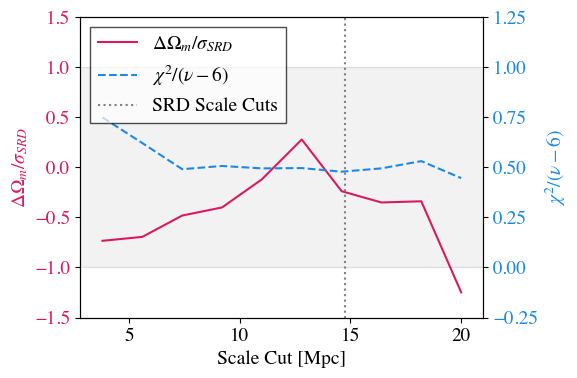

In [49]:
fig, ax1 = plt.subplots(figsize=(6, 4))

OmM_fid=0.339
OmM_err=0.042

color = '#D81B60'
ax1.set_xlabel('Scale Cut [Mpc]')
ax1.set_ylabel('$\\Delta \\Omega_m/\\sigma_{SRD}$', color=color)
ax1.fill_between([0, 25], -1, 1, alpha=.1, edgecolor='black', facecolor='gray')

ax1.plot((angles_to_try/1000)[1:], (np.array([res.x[0] for res in reslist][1:]) - OmM_fid) / OmM_err, color=color, 
         label='$\\Delta \\Omega_m/\\sigma_{SRD}$',)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = '#1E88E5'
ax2.set_ylabel('$\\chi^2/(\\nu-6)$', color=color)  # we already handled the x-label with ax1
ax2.plot((angles_to_try/1000)[1:], np.divide(chi2_list, np.subtract(dof_list, 6))[1:], color=color, ls='--', label='$\\chi^2/(\\nu-6)$')
ax2.tick_params(axis='y', labelcolor=color)
ax2.vlines(txp_val, -2, 2, color='gray', ls=':', zorder=0, label='SRD Scale Cuts')
# ax2.set_ylim(.22, .65)
ax2.set_ylim(-0.25, 1.25)
ax1.set_ylim(-1.5, 1.5)
ax1.set_xlim(2.8, 21)

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left', fancybox=False, framealpha=.7, edgecolor='0')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
# plt.show()
# plt.savefig('scale_cuts_adj.png', dpi=300, format='png', bbox_inches='tight')

In [50]:
resx_arr = np.insert(np.array([res.x[0] for res in reslist][1:]), 7, OmM_fid)
scalecut_arr = np.insert((angles_to_try/1000)[1:], 7, txp_val)

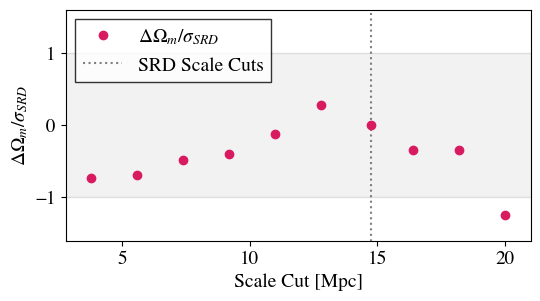

In [51]:
plt.figure(figsize=(6, 3))

OmM_fid=0.339
OmM_err=0.042

color = '#D81B60'
plt.xlabel('Scale Cut [Mpc]')
plt.ylabel('$\\Delta \\Omega_m/\\sigma_{SRD}$',)
plt.fill_between([0, 25], -1, 1, alpha=.1, edgecolor='black', facecolor='gray')

plt.plot(np.delete(scalecut_arr,6), (np.delete(resx_arr,6) - OmM_fid) / OmM_err, color=color, 
         label='$\\Delta \\Omega_m/\\sigma_{SRD}$',
         marker='o',
         ls='')

color = '#1E88E5'

plt.vlines(txp_val, -2, 2, color='gray', ls=':', zorder=0, label='SRD Scale Cuts')
plt.ylim(-1.6, 1.6)
plt.xlim(2.8, 21)

plt.legend(loc='upper left', fancybox=False, framealpha=.8, edgecolor='0')

fig.tight_layout()
# plt.show()
# plt.savefig('scale_cuts_OmM.png', dpi=300, format='png', bbox_inches='tight')

/var/folders/d1/k792r3jx2dnfdzf197jwm17m0000gn/T/ipykernel_38575/222868373.py:26: RuntimeWarning: divide by zero encountered in divide
  ax2.set_xscale('function', functions=(lambda b: 1/b, lambda b: b))


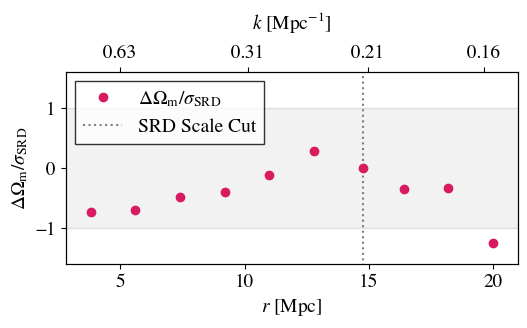

In [53]:
fig, ax1 = plt.subplots(figsize=(5.5, 3.5))

OmM_fid=0.339
OmM_err=0.042

color = '#D81B60'
ax2 = ax1.twiny()

ax1.set_xlabel('$r$ [Mpc]')
ax1.set_ylabel('$\\Delta \\Omega_{\\rm m}/\\sigma_{\\rm SRD}$',)
ax1.fill_between([0, 25], -1, 1, alpha=.1, edgecolor='black', facecolor='gray')

ax1.plot(np.delete(scalecut_arr,6), (np.delete(resx_arr,6) - OmM_fid) / OmM_err, color=color, 
         label='$\\Delta \\Omega_{\\rm m}/\\sigma_{\\rm SRD}$',
         marker='o',
         ls='')

color = '#1E88E5'

ax1.vlines(txp_val, -2, 2, color='gray', ls=':', zorder=0, label='SRD Scale Cut')
ax1.set_ylim(-1.6, 1.6)
ax1.set_xlim(2.8, 21)

ax2.set_xlabel('$k$ [Mpc$^{-1}$]', labelpad=11)
ax2.set_xlim(np.pi/ax1.get_xlim()[1], np.pi/ax1.get_xlim()[0])
ax2.set_xscale('function', functions=(lambda b: 1/b, lambda b: b))
ax2.set_xticks([.16, .21, .31, .63])
# ax2.set_xticklabels(np.delete(scalecut_arr,6)[::-1])

ax1.legend(loc='upper left', fancybox=False, framealpha=.8, edgecolor='0')

fig.tight_layout()
# plt.show()
plt.savefig('scale_cuts_OmM_withk.png', dpi=300, format='png', bbox_inches='tight')

In [68]:
ax1.get_xlim()[0]

2.8

In [69]:
np.pi/ax1.get_xlim()[0], np.pi/ax1.get_xlim()[1]

(1.121997376282069, 0.14959965017094254)

# Skysim Patches

In [39]:
# Load in skysim_all:
skysim_all_data = pd.DataFrame()
covlist = []
nz_df = pd.DataFrame()
zmin=0.2
for i in range(5):
    zmax=zmin+.2
    tab = astropy.table.Table.read(f'skysim5000/w_skysim_all_24p1/w_skysim5000_{zmin:.1f}_{zmax:.1f}_lt24p1_all_norsd.fits.gz')
    skysim_all_data[f'theta_{i}'] = tab['theta']
    skysim_all_data[f'w_{i}'] = tab['w']
    skysim_all_data[f'werr_{i}'] = tab['w_err']
    nz_tab = astropy.table.Table.read(f'skysim5000/w_skysim_all_24p1/dndz_skysim5000_{zmin:.1f}_{zmax:.1f}_lt24p1_all_norsd.fits.gz')
    nz_df[f'z_{i}'] = nz_tab['z']
    nz_df[f'Nz_{i}'] = nz_tab['dndz']
    covlist.append(np.load(f'skysim5000/w_skysim_all_24p1/skysim_{0.2+0.2*i:.1f}_{0.4+0.2*i:.1f}_lt24p1_all_cov_norsd.npy'))
    # print(f'skysim5000/w_skysim_all_24p1/w_skysim5000_{zmin:.1f}_{zmax:.1f}_lt24p1_all_norsd.fits.gz')
    zmin+=.2


In [40]:
# Load in skysim patches:
full_list = []
for idx1 in range(3):
    idx_list = []
    for idx2 in range(4):
        df_list = []
        for zbin in range(5):
            zmin = np.round(0.2 + (0.2*zbin), 2)
            zmax = np.round(0.4 + (0.2*zbin), 2)
            # print(idx1, idx2, zmin, zmax)
            wtheta = astropy.table.Table.read(f'skysim5000/w_skysim_patches_24p1/w_skysim5000_{zmin}_{zmax}_lt24p1_all_norsd_{idx1}_{idx2}.fits.gz')
            df_list.append(pd.DataFrame([wtheta['theta'], wtheta['w']]).rename(index={0: f"theta_{zbin}", 1: f"w_{zbin}"}).T)
        full_list.append(pd.concat(df_list, axis=1))

In [41]:
# Get summary statistics for skysim patches:
dc2_truth = data_vector_list['true_all'][0]

w_mean = []
w_std = []
for i in range(5):
    w_mean.append(np.mean([df[f'w_{i}'] for df in full_list], axis=0))
    w_std.append(np.std([df[f'w_{i}'] for df in full_list], axis=0))

In [52]:
# MODEL+RESIDUAL PLOTTER
txp_angles = [42.81, 26.93, 20.21, 16.52, 14.21]
cosmodc2_color = '#e5197b'
skysim_color = '#72ad80'
skysim_color_shading = '#caedd2'

def plot_allwtheta_residual_test_skysim_patches(
    resid_limits=(-3, 2),
    delta_or_ratio="delta",
    yticks=None,
):
    # STYLES
    marker = "."
    capsize = 2
    ls = "-"
    markersize = 7
    lw = 1.5
    model_color = "#273E47"
    resid_label = "$\\Delta w/\\sigma_{w}$"

    # PLOT
    fig, axs = plt.subplots(2, 5, figsize=(15, 3), height_ratios=[4, 1])
    for i in range(len(axs[1])):
        axs[0][i].set_title(
            f"${np.round((.2*i)+.2, 2)} < z < {np.round((.2*i)+.4, 2)}$"
        )
        axs[0][i].axvspan(
            0, txp_angles[i], alpha=0.1, edgecolor="black", facecolor="gray"
        )
        axs[0][i].fill_between(skysim_all_data[f'theta_{i}'], 
                               skysim_all_data[f'theta_{i}']*(w_mean[i]-w_std[i]), 
                               skysim_all_data[f'theta_{i}']*(w_mean[i]+w_std[i]), 
                               edgecolor=skysim_color, 
                               facecolor=skysim_color_shading, 
                               alpha=1)
        axs[0][i].errorbar(skysim_all_data[f'theta_{i}'],#*(offset), 
                    skysim_all_data[f'theta_{i}']*skysim_all_data[f'w_{i}'],
                    skysim_all_data[f'theta_{i}']*skysim_all_data[f'werr_{i}'], 
                    color=skysim_color, label='SkySim5000',
                    lw=lw,)
        axs[0][i].errorbar(dc2_truth[f'theta_{i}'],#*(offset), 
                    dc2_truth[f'theta_{i}']*dc2_truth[f'w_{i}'],
                    dc2_truth[f'theta_{i}']*dc2_truth[f'werr_{i}'], 
                    color=cosmodc2_color, label='CosmoDC2',
                    # marker=marker,
                    # capsize=capsize,
                    ls=':',
                    # markersize=markersize,
                    lw=lw,
                    zorder=100,)
        # offset += .05
        residual_plot_helper(axs, 0, i, "linear")
        axs[0][i].set_ylim(-0.19, 0.6)
        axs[0][i].axes.xaxis.set_ticklabels([])
        # RESIDUALS
        axs[1][i].axvspan(
            0, txp_angles[i], alpha=0.1, edgecolor="black", facecolor="gray"
        )
        
        axs[1][i].axhline(0, 0, 500, color="black", ls=":")
        
        axs[1][i].plot(dc2_truth[f'theta_{i}'], 
                    (dc2_truth[f'w_{i}'] - skysim_all_data[f'w_{i}']) / dc2_truth[f'werr_{i}'],
                    color=cosmodc2_color,
                    # marker=marker,
                    # capsize=capsize,
                    ls=ls,
                    # markersize=markersize,
                    lw=lw,)
            
        residual_plot_helper(axs, 1, i, "linear")
        axs[1][i].set_ylim(resid_limits[0], resid_limits[1])
        axs[1][i].set_xlabel("$\\theta$ [arcmin]")
        if yticks is not None:
            axs[1][i].set_yticks(yticks)
        axs[1][i].set_yticks((-3, 0, 3))
        if i == 0:
            axs[0][i].set_ylabel("$\\theta \\times w(\\theta)$")
            axs[1][i].set_ylabel(resid_label, labelpad=5)
        else:
            axs[0][i].axes.yaxis.set_ticklabels([])
            axs[1][i].axes.yaxis.set_ticklabels([])
        # if i == 2:
        #     axs[0][i].legend(loc="upper center", ncol=2, bbox_to_anchor=(0.5, 1.5), fancybox=False, framealpha=1, edgecolor='0')
        if i == 0:
            axs[0][i].legend(loc="lower left", ncol=1, fancybox=False, framealpha=1, edgecolor='0')
    fig.subplots_adjust(hspace=0, wspace=0.1)
    # plt.show()
    plt.savefig('skysim_dc2_datavector_thetaxw.png', dpi=300, format='png', bbox_inches='tight')
    

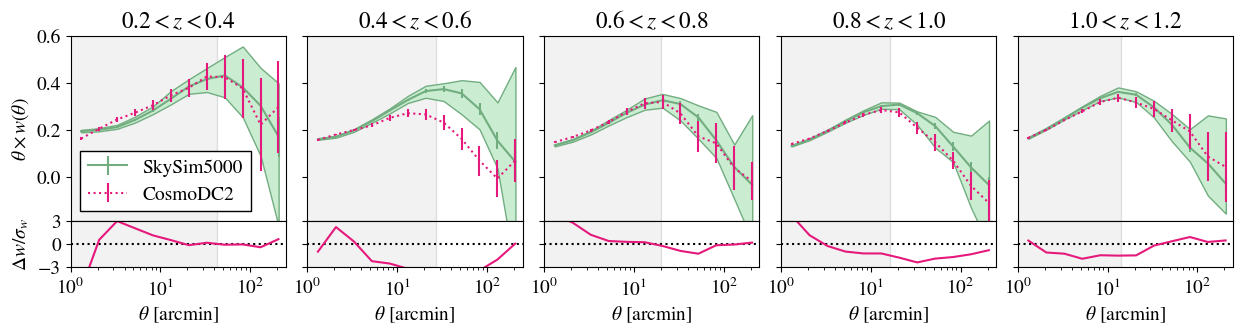

In [53]:
plot_allwtheta_residual_test_skysim_patches(resid_limits=(-3, 3))